# multiSWAG_CLs

This module gets cosmological constraints from simulations of the CMB Cls using MultiSWAG

In [1]:
import os
import sys
import numpy as np
import torch
sys.path.append("../cosmoswag") 
from swag import SWAGModel
from cmb_simulator import normalize_params, bin_cls
os.environ["OMP_NUM_THREADS"] = "1"

#### Load the data

In [2]:
cls = np.load('../cosmoswag/data/cmb_sims/cls.npy')
params = np.load('../cosmoswag/data/cmb_sims/params.npy')

theta_norm = normalize_params(params)
_, binned_cls = bin_cls(cls, 250)

x_train = torch.tensor(binned_cls[:-1000], dtype = torch.float32)
y_train = torch.tensor(theta_norm[:-1000], dtype = torch.float32)
x_val = torch.tensor(binned_cls[-1000:], dtype = torch.float32)
y_val = torch.tensor(theta_norm[-1000:], dtype = torch.float32)

#### Set up the model

In [3]:
nin = x_train.shape[1]
npars = y_train.shape[1]
model = SWAGModel(nin=nin, npars = npars)

#### Train the model

In [4]:
model.train(x_train, y_train, x_val, y_val, num_epochs=1000, num_workers=4)

  0%|          | 0/1000 [00:00<?, ?it/s]

-6.468251713044942
-8.684000368118285
-10.042971790075303
-10.963573314666748
-11.75559423828125
-12.345546853542327
-13.0621026802063
-13.33070939540863
-13.747318169593811
-13.880367289543152
-14.21072935128212
-14.422856132030487
-14.585385059833527
-14.659226699829102
-14.937807697296142
-15.12814252758026
-15.175326966285706
-15.333603578090667
-15.5980938911438
-15.501675842285156
-15.466918100833892
-15.907477122306824
-15.944769948959351
-15.944108035087586
-15.947532598972321
-16.155468578338624
-16.3186259765625
-16.46942390155792
-16.4266621761322
-16.416811724662782
-16.37236169242859
-16.567069575309752
-16.53030629825592
-16.57252729892731
-16.72109313774109
-16.804513341903686
-16.63850757217407
-16.645695993423463
-16.72141194152832
-16.94272565460205
-16.927290348052978
-16.9880840511322
-16.905860010147094
-16.953386700630187
-17.069968658447266
-17.078384046554564
-17.05252625274658
-17.216133366584778
-16.942270008087156
-17.234126335144044
-17.269711824417115
-17.0

In [9]:
avg_w = model.w_avg  # [K]
avg_w2 = model.w2_avg  # [K]
sigma = torch.abs(torch.diag(avg_w2 - avg_w ** 2))

def sample_weights(model, sigma, scale=1):
    with torch.no_grad():
        avg_w = model.w_avg  # [K]
        avg_w2 = model.w2_avg  # [K]
        D = model.pre_D - avg_w[:, None]  # [d, K]
        d = avg_w.shape[0]
        K = model.K
        z_1 = torch.randn((1, d))#, device=self.device)
        z_2 = torch.randn((K, 1))#, device=self.device)

        w = avg_w[None] + scale * (1.0 / np.sqrt(2.0)) * z_1 @ sigma ** 0.5
        w += scale * (D @ z_2).T / np.sqrt(2 * (K - 1))
        w = w[0]
        
        return w

In [10]:
samples = torch.zeros([1000, 20904])
for i in range(20904):
    samples[i] = sample_weights(model, sigma)

IndexError: index 1000 is out of bounds for dimension 0 with size 1000

In [16]:
samples_np = samples.detach().numpy()

In [17]:
samples

tensor([[ 1.1318,  1.0939,  1.0449,  ..., -2.0204, -0.1713, 11.1377],
        [ 1.1307,  1.0938,  1.0448,  ..., -2.0257, -0.1771, 11.1217],
        [ 1.1313,  1.0940,  1.0448,  ..., -2.0249, -0.1782, 11.1365],
        ...,
        [ 1.1315,  1.0928,  1.0448,  ..., -2.0238, -0.1914, 11.1124],
        [ 1.1316,  1.0942,  1.0449,  ..., -2.0205, -0.1705, 11.1422],
        [ 1.1319,  1.0949,  1.0450,  ..., -2.0162, -0.1651, 11.1476]])

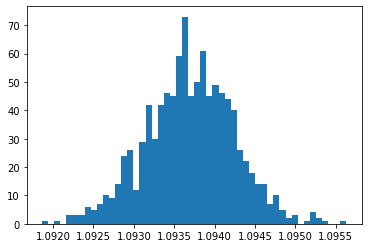

In [19]:
from matplotlib import pyplot as plt 
plt.hist(samples_np[:,1], 50);

In [27]:
samps = torch.zeros([1000, 1000, 20])
for i in range(1000):
    if i%51 == 50: print(i)
    samps[i] = model.forward_swag(x_val)

50
101
152
203
254
305
356
407
458
509
560
611
662
713
764
815
866
917
968


In [57]:
mu, invcov = model.separate_mu_cov(samps[:,-2,:])

In [58]:
mean = mu.detach().numpy()
cov = torch.inverse(invcov).detach().numpy()

maxs = np.array([90, 0.05, 0.5, 3.5, 1])
mins = np.array([50, 0.01, 0.01, 1.5, 0.8])

mean = mean*(maxs-mins)+mins
cmaxs = np.outer(maxs, maxs)
cmins = np.outer(mins, mins)
cov = cov*(cmaxs-cmins)
#X = np.random.multivariate_normal(mean, cov, 10000)

In [59]:
X = np.zeros([1000, 100, 5])
for i in range(1000):
    X[i] = np.random.multivariate_normal(mean[i], cov[i], 100)
    
X = X.reshape([-1, 5])

/Users/pablo/miniconda3/envs/swag/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
import getdist.plots
names = ["H0", "omch2",  "ombh2", "As", "ns"]
labels =  ["H_0", "\Omega_\mathrm{c} h^2", "\Omega_\mathrm{b} h^2", "\log A", "n_s"]
swag = getdist.MCSamples(samples=X,names = names, labels = labels)

Removed no burn in


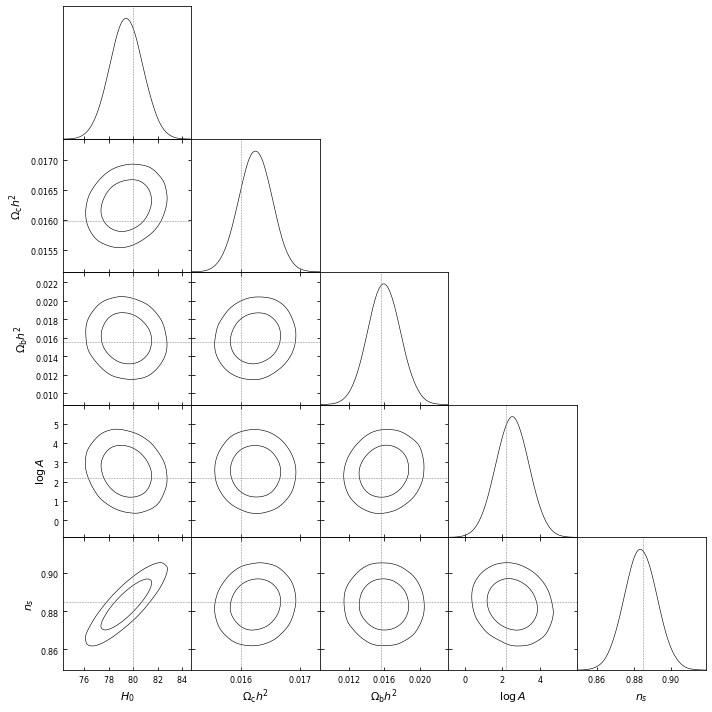

In [61]:
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(swag,
                filled = True,
                markers={'H0':params[-2,0],
                         'omch2':params[-2,1],
                         'ombh2':params[-2,2],
                         'As':params[-2,3],
                         'ns':params[-2,4]})